In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import pickle
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from prettytable import PrettyTable
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.markers import MarkerStyle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

## Divide new_datas into four seasons
npz_month = npzfile['month']
winter_ids = np.where( (npz_month==12) | (npz_month==1) | (npz_month==2) )[0]
spring_ids = np.where( (npz_month==3) | (npz_month==4) | (npz_month==5) )[0]
summer_ids = np.where( (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
fall_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) )[0]

print(npz_month.shape)
print(winter_ids.shape)
print(spring_ids.shape)
print(summer_ids.shape)
print(fall_ids.shape)

(16026,)
(3940,)
(4048,)
(4048,)
(3990,)


In [3]:
seasons = ['winter','spring','summer','fall']
seasons_ids = [winter_ids, spring_ids, summer_ids, fall_ids]
data_names = npzfile.files
n_files = len(npzfile.files)

season_datas = {}
for j in range(4):
    season = seasons[j]
    season_id = seasons_ids[j]

    new_datas = [0]*n_files
    for i in range(n_files):
        new_datas[i] = npzfile[data_names[i]][season_id]

    season_datas[season] = new_datas

#example
season_datas['winter']

[array([1979, 1979, 1979, ..., 2022, 2022, 2022]),
 array([1, 1, 1, ..., 2, 2, 2]),
 array([ 1,  2,  3, ..., 26, 27, 28]),
 array([ 0.142507  , -0.2042    , -0.15861   , ...,  0.28864297,
         0.42139462,  0.28795415]),
 array([ 1.05047   ,  1.37361   ,  1.53943   , ..., -0.29837567,
        -0.13990659, -0.09597149]),
 array([6., 7., 7., ..., 3., 4., 4.]),
 array([1.0600899 , 1.3887    , 1.54758   , ..., 0.41514191, 0.4440127 ,
        0.30352613])]

In [4]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = False

Ns = [len(winter_ids),len(spring_ids),len(summer_ids),len(fall_ids)]# the total number of days in new dataset
n = 2500 # the number of days for training
c = 365 # the number of dropped buffer set
ms = [N-n-c for N in Ns] # the number of days for testing


n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]
n1s = [2165]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=nu, ard_num_dims=d) 

In [5]:
print(ms)
max_lead_time = [m + 1 - max(widths) for m in ms]
print(max_lead_time)

[1075, 1183, 1183, 1125]
[996, 1104, 1104, 1046]


In [6]:
lead_time = 60
n_pred = 2*365 # 14*365
# width + lead_time + n_pred-1 <= m

## $Mat\acute{e}rn$ $1/2$

### Independent RMMs with $Mat\acute{e}rn$ $1/2$

In [7]:
# Independent
dics_total_matern12 = {}
cor_total_matern12 = {}
rmse_total_matern12 = {}
phase_err_total_matern12 = {}
amplitude_err_total_matern12 = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscale"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_matern12[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            for data_name in ['RMM1','RMM2']:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
                t.add_rows( [[f'{season}', f'{width}', f'{data_name}', f'{mjo_model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0]}']] )
                
            
            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_matern12[season] = cor_n1
    rmse_total_matern12[season] = rmse_n1
    phase_err_total_matern12[season] = phase_err_n1
    amplitude_err_total_matern12[season] = amplitude_err_n1

matern12_independ = {'cor': cor_total_matern12, 'rmse': rmse_total_matern12, 
                     'phase': phase_err_total_matern12, 'amplitude': amplitude_err_total_matern12,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/matern12_independ.pkl','wb')
pickle.dump(matern12_independ, dic_pkl)

print(f'Matern 1/2 with independent RMMs:')
print(t)

Matern 1/2 with independent RMMs:
+--------+-------+------+--------------+
| season | width | RMMs | lengthscale  |
+--------+-------+------+--------------+
| winter |   40  | RMM1 | [7.4323626]  |
| winter |   40  | RMM2 | [17.858154]  |
| winter |   60  | RMM1 | [31.433104]  |
| winter |   60  | RMM2 | [45.753136]  |
| winter |   80  | RMM1 | [59.761448]  |
| winter |   80  | RMM2 |  [70.15951]  |
| spring |   40  | RMM1 |  [74.68455]  |
| spring |   40  | RMM2 | [78.243164]  |
| spring |   60  | RMM1 |  [84.30177]  |
| spring |   60  | RMM2 | [88.859505]  |
| spring |   80  | RMM1 |  [94.8031]   |
| spring |   80  | RMM2 | [98.926926]  |
| summer |   40  | RMM1 |  [99.83946]  |
| summer |   40  | RMM2 | [100.682724] |
| summer |   60  | RMM1 | [103.93751]  |
| summer |   60  | RMM2 |  [106.6584]  |
| summer |   80  | RMM1 | [110.439896] |
| summer |   80  | RMM2 | [114.067825] |
|  fall  |   40  | RMM1 | [114.50301]  |
|  fall  |   40  | RMM2 | [114.248146] |
|  fall  |   60  | RMM1

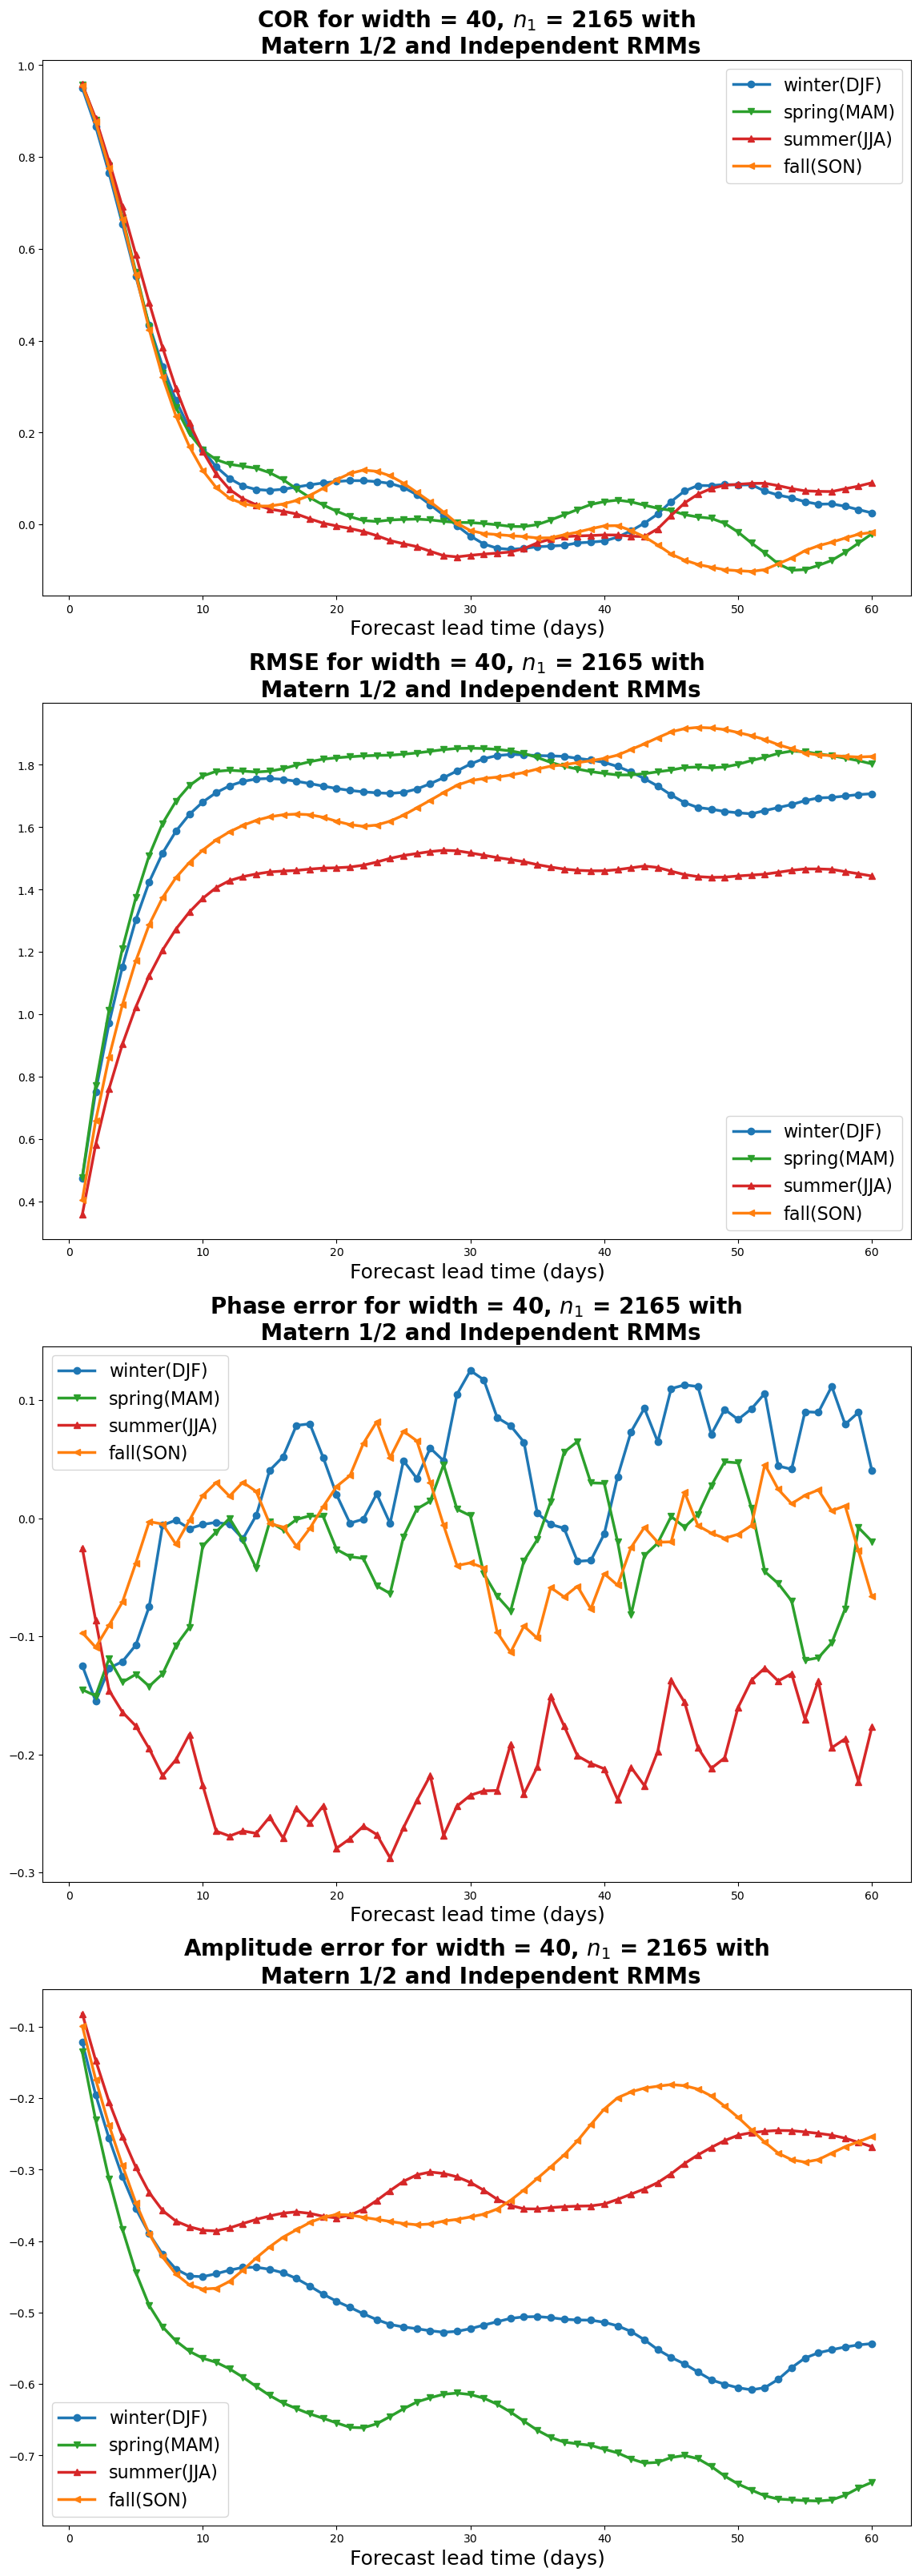

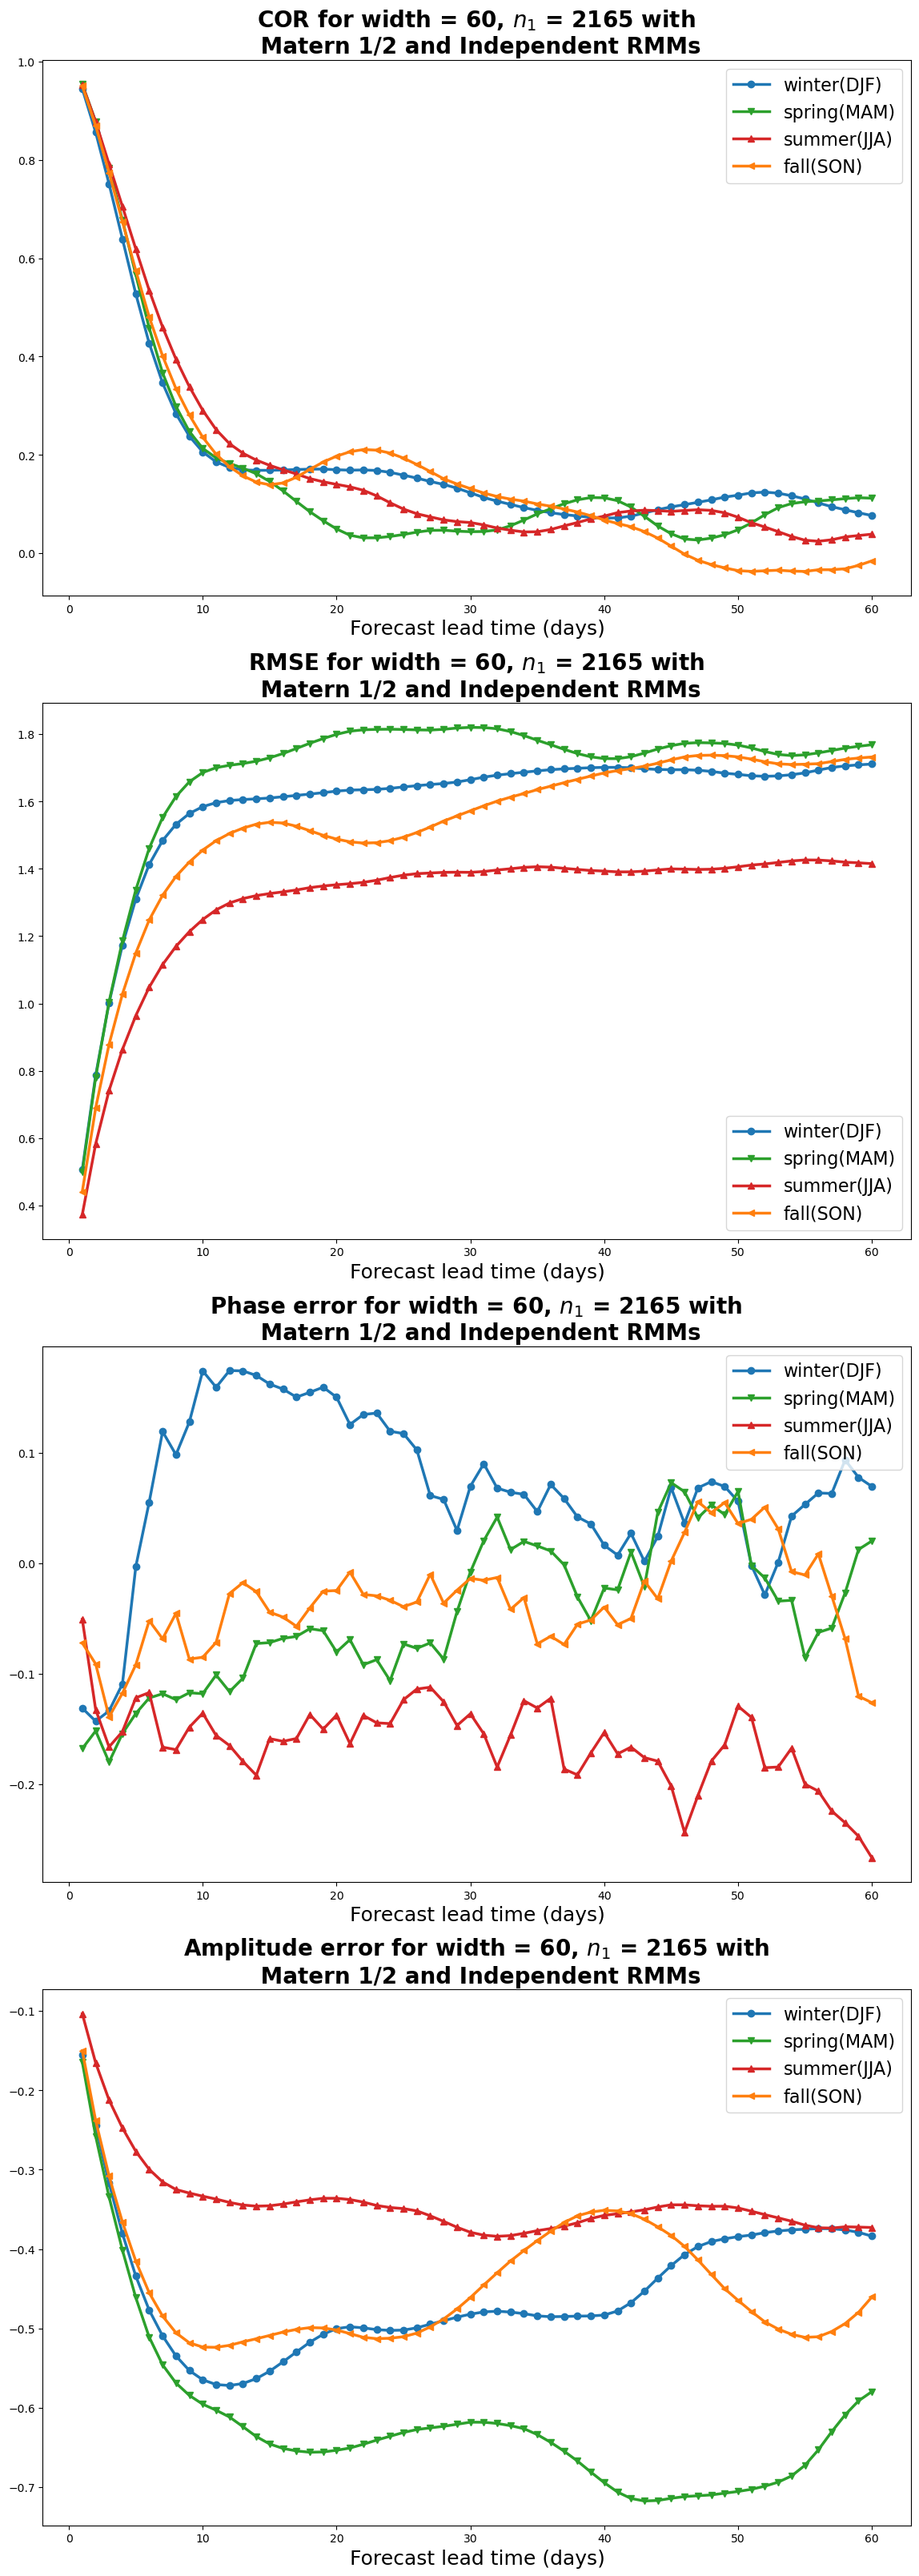

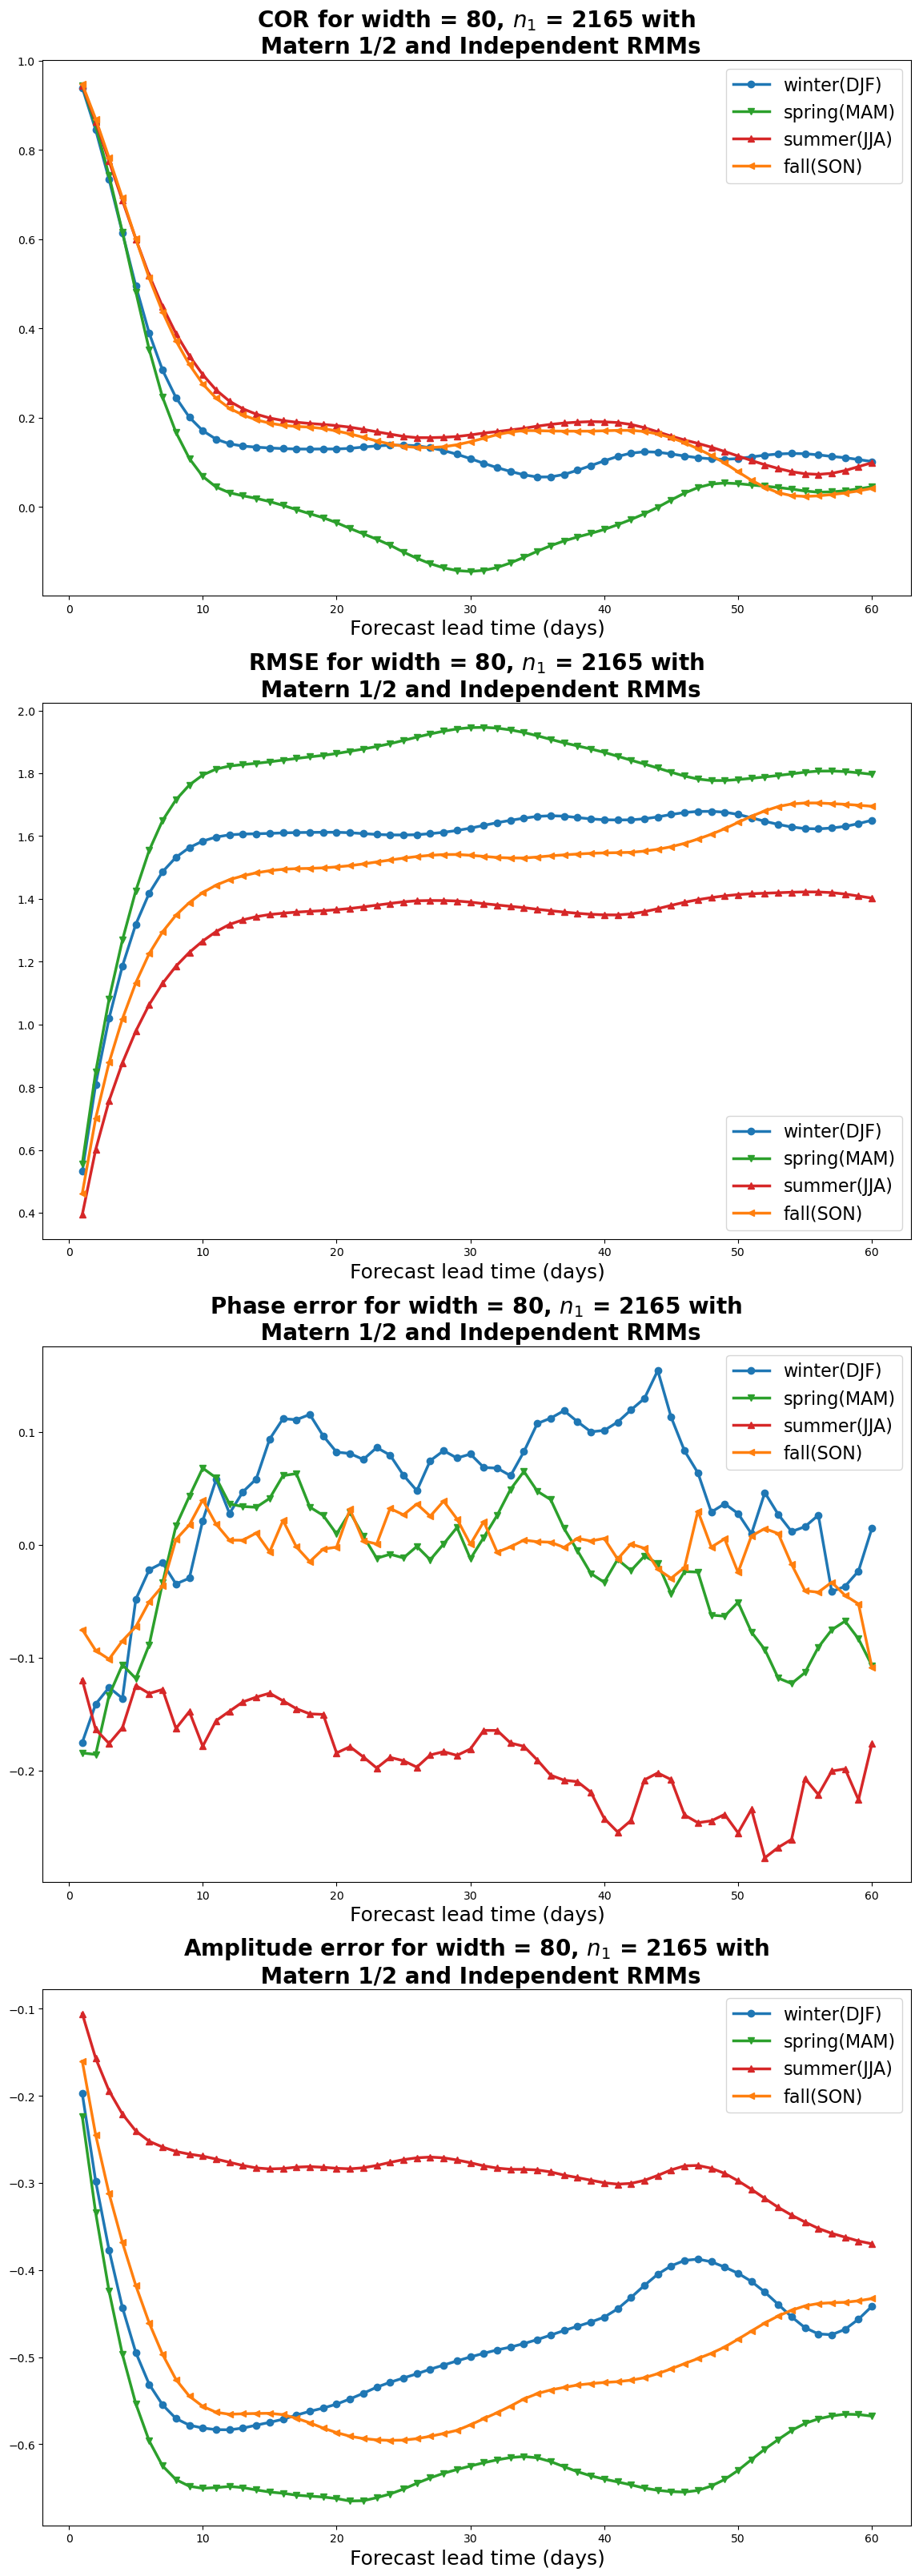

In [8]:
load_file = open('../data/preds/season/matern12_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())

# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Matern 1/2 and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs with $Mat\acute{e}rn$ $1/2$

In [9]:
# Dependent
dics_total_dependmatern12 = {}
cor_total_dependmatern12 = {}
rmse_total_dependmatern12 = {}
phase_err_total_dependmatern12 = {}
amplitude_err_total_dependmatern12 = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscale"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_dependmatern12[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo(Depend=True)
            for data_name in ['RMM1','RMM2']:    
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
            t.add_rows( [[f'{season}', f'{width}', 'dependent', f'{mjo_model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0]}']] )

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_dependmatern12[season] = cor_n1
    rmse_total_dependmatern12[season] = rmse_n1
    phase_err_total_dependmatern12[season] = phase_err_n1
    amplitude_err_total_dependmatern12[season] = amplitude_err_n1

matern12_depend = {'cor': cor_total_dependmatern12, 'rmse': rmse_total_dependmatern12, 
                     'phase': phase_err_total_dependmatern12, 'amplitude': amplitude_err_total_dependmatern12,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/matern12_depend.pkl','wb')
pickle.dump(matern12_depend, dic_pkl)

print(f'Matern 1/2 with dependent RMMs:')
print(t)

Matern 1/2 with dependent RMMs:
+--------+-------+-----------+--------------+
| season | width |    RMMs   | lengthscale  |
+--------+-------+-----------+--------------+
| winter |   40  | dependent | [121.54381]  |
| winter |   60  | dependent | [122.51238]  |
| winter |   80  | dependent | [124.73563]  |
| spring |   40  | dependent | [122.022896] |
| spring |   60  | dependent | [122.85413]  |
| spring |   80  | dependent | [124.97075]  |
| summer |   40  | dependent | [123.72657]  |
| summer |   60  | dependent | [125.25133]  |
| summer |   80  | dependent | [127.900925] |
|  fall  |   40  | dependent |  [127.0593]  |
|  fall  |   60  | dependent | [128.73782]  |
|  fall  |   80  | dependent | [131.99173]  |
+--------+-------+-----------+--------------+


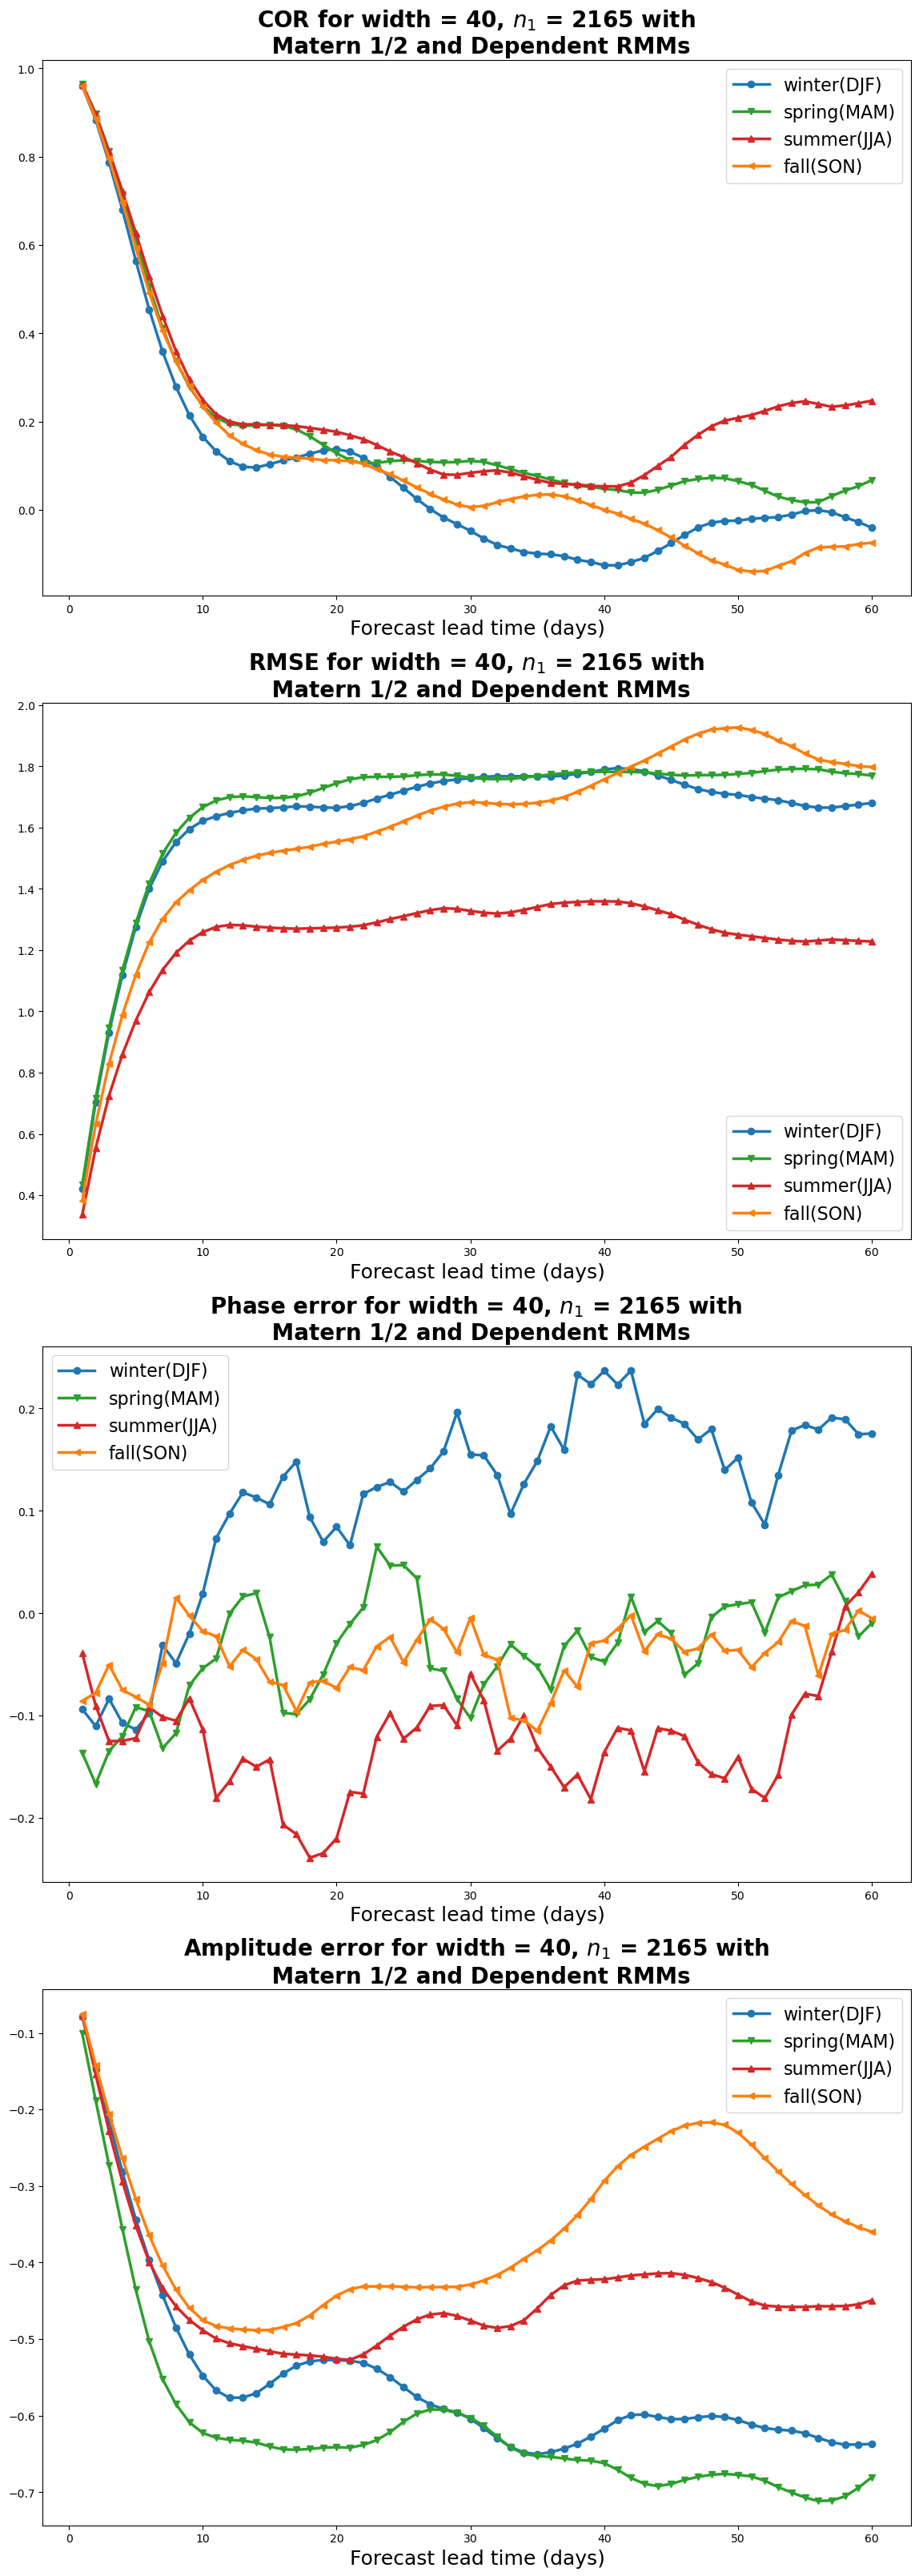

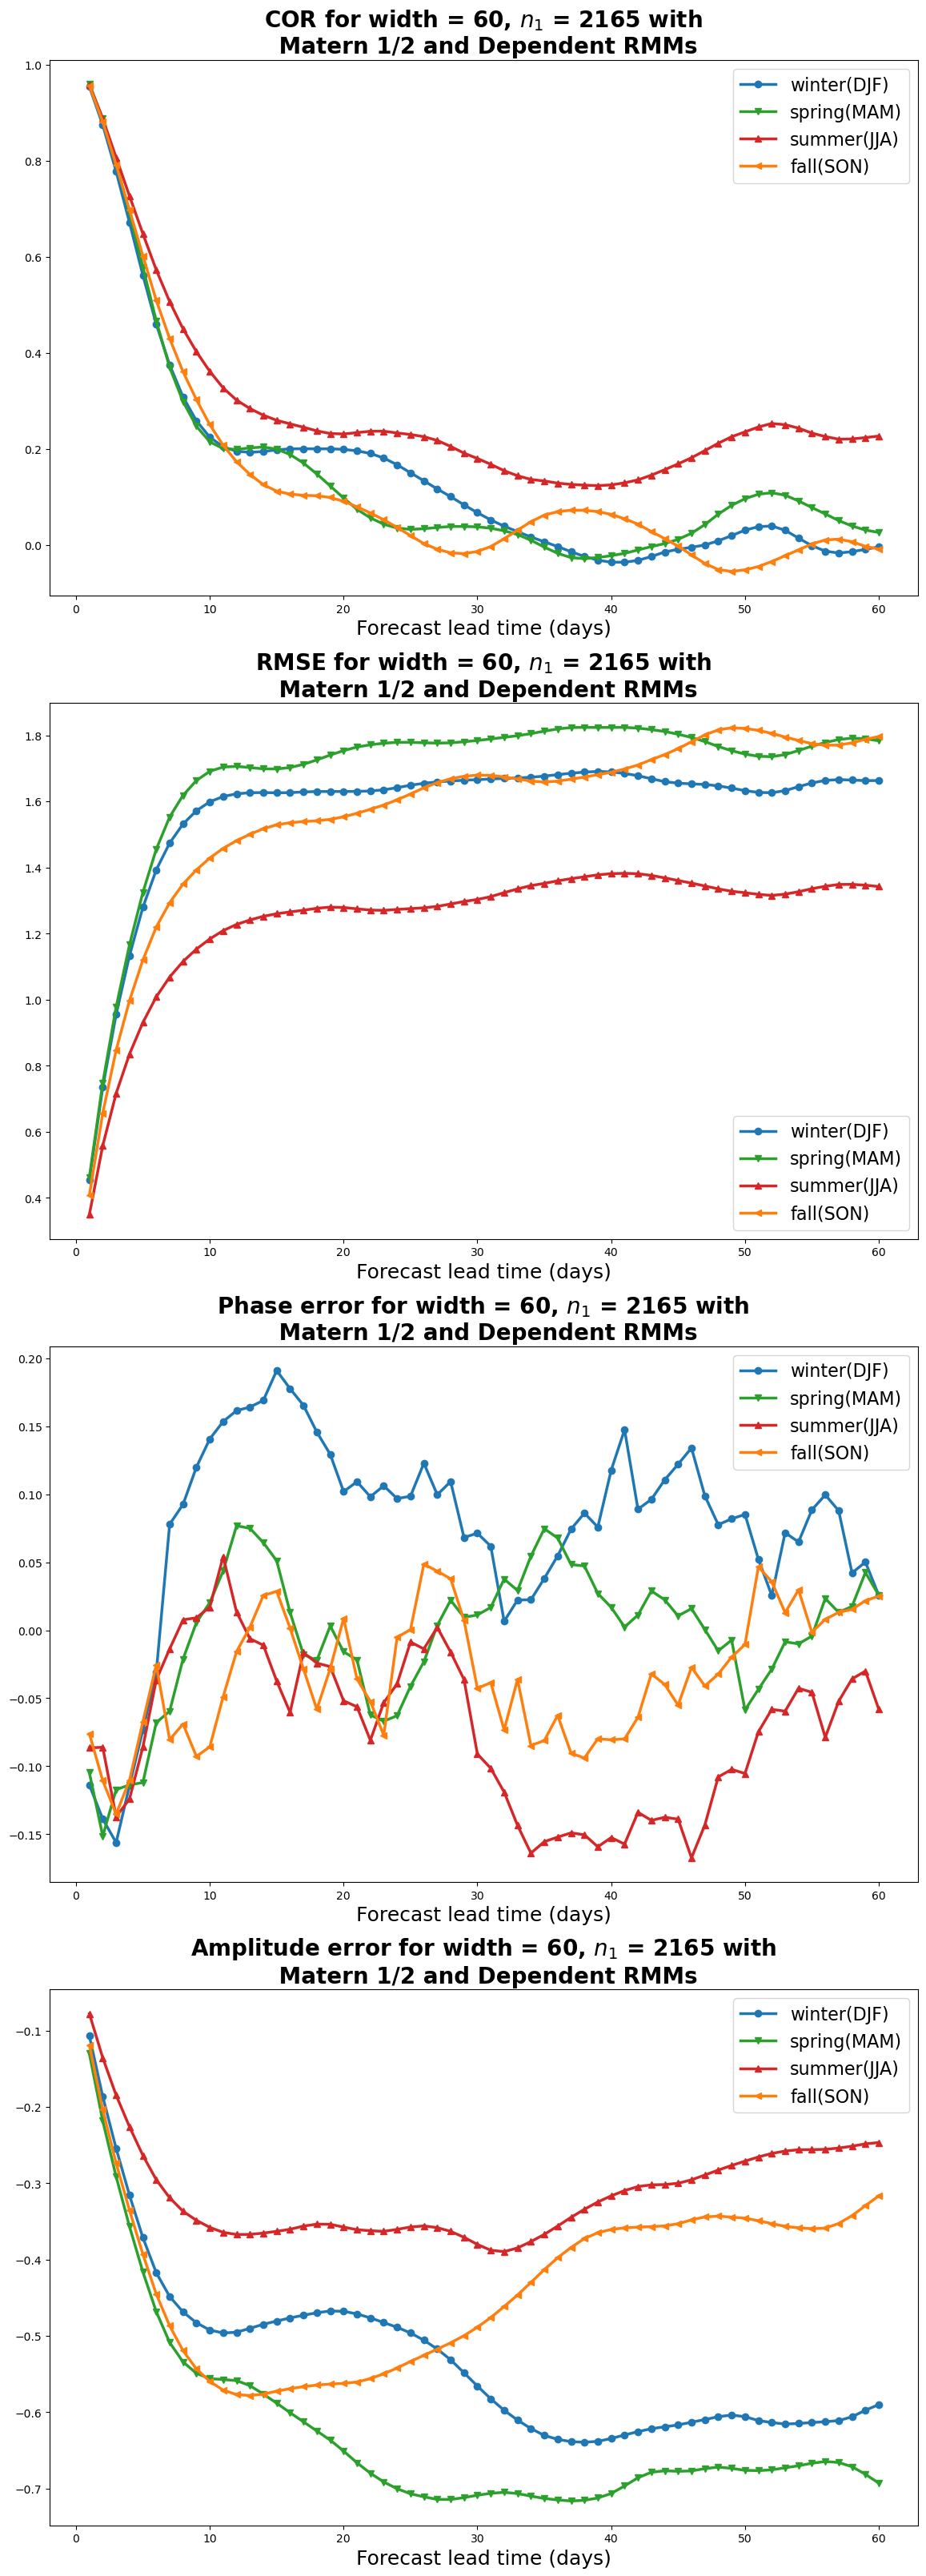

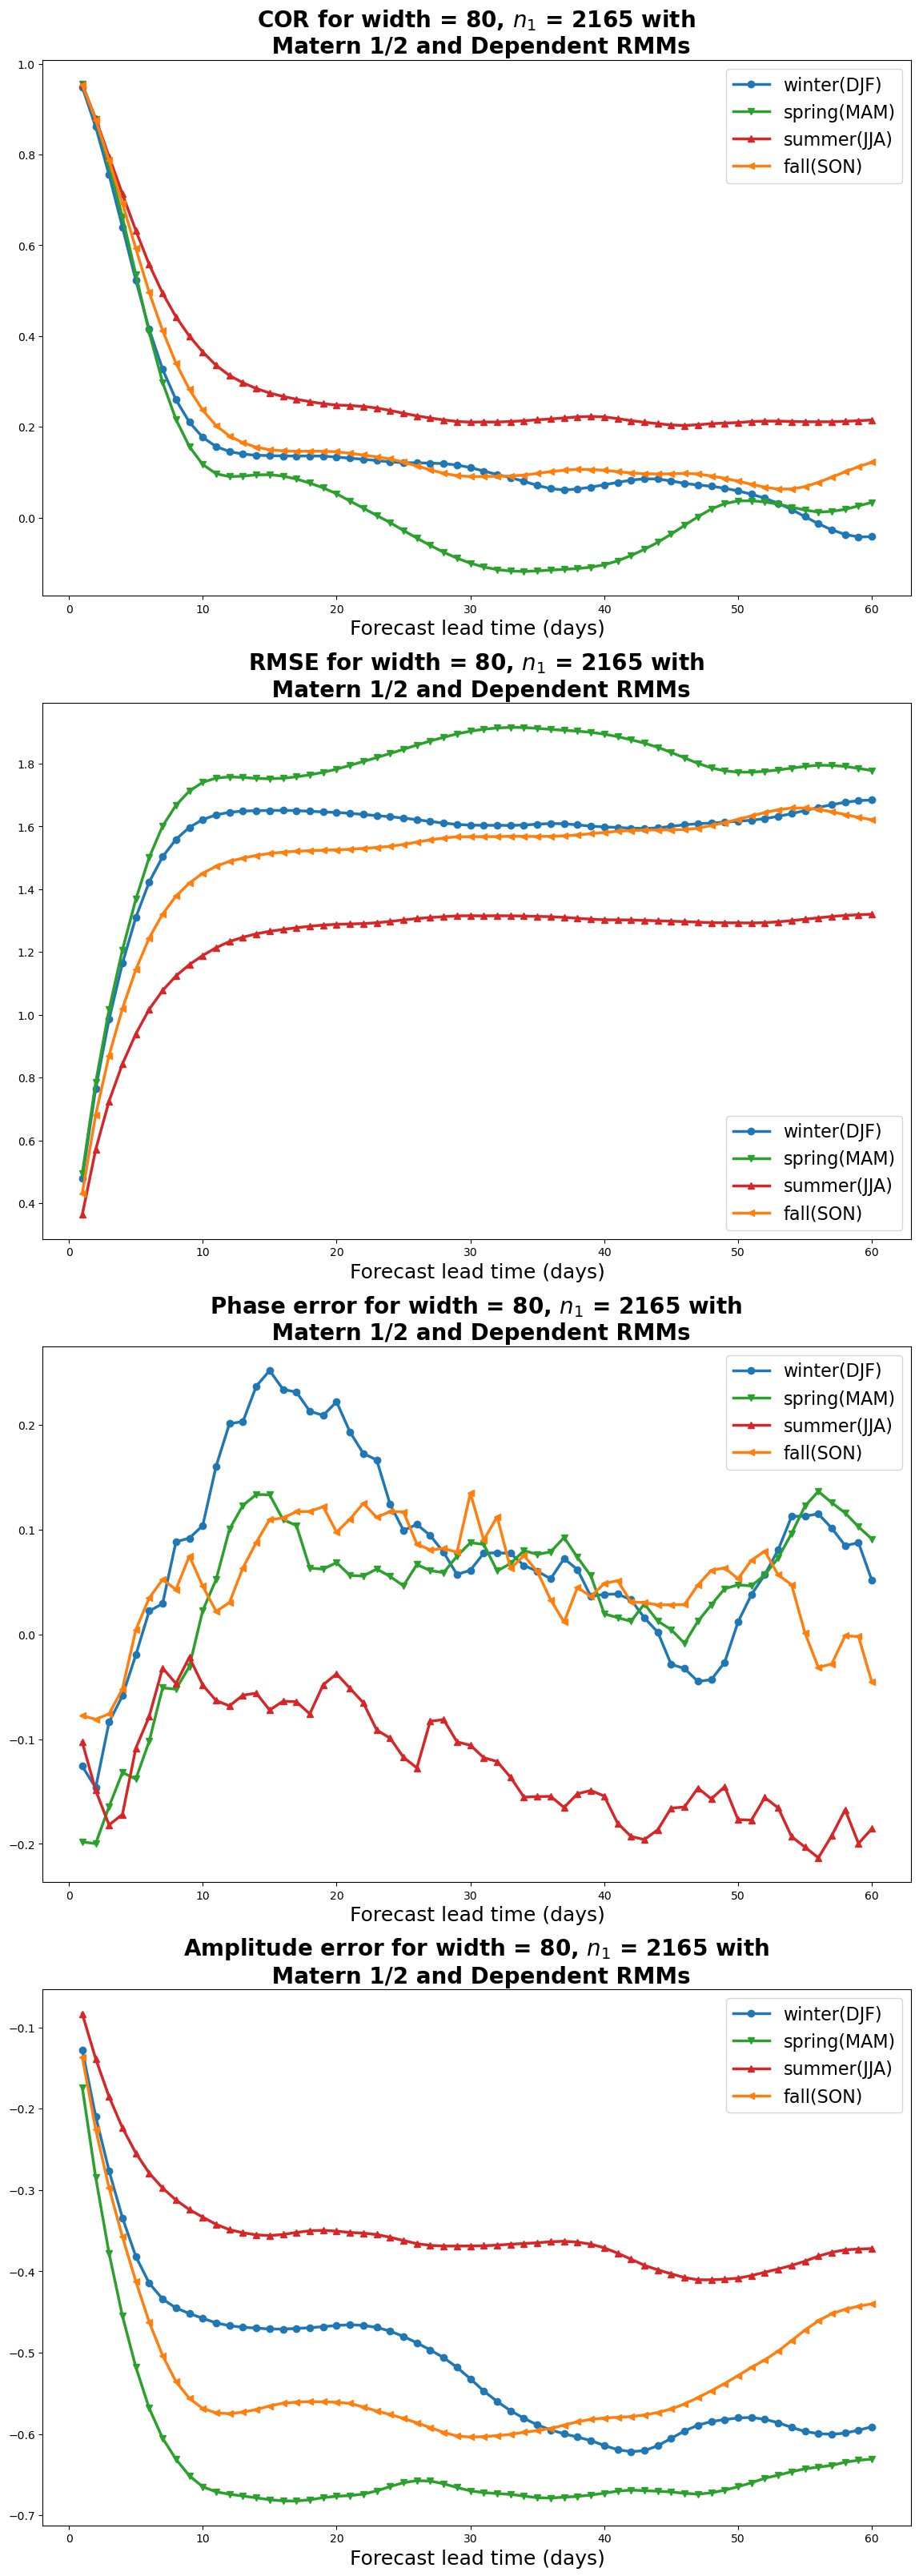

In [10]:
load_file = open('../data/preds/season/matern12_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())

# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Matern 1/2 and Dependent RMMs', fontsize=20, fontweight="bold")

## $w_1$ $Mat\acute{e}rn$ $1/2$ + $w_2$ $Mat\acute{e}rn$ $3/2$ + $w_3$ $Mat\acute{e}rn$ $5/2$

### Independent RMMs

In [7]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern import MaternAdditiveKernel
kernel = MaternAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_additivematern = {}
cor_total_additivematern = {}
rmse_total_additivematern = {}
phase_err_total_additivematern = {}
amplitude_err_total_additivematern = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscales", "weights"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_additivematern[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            for data_name in ['RMM1','RMM2']:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
                weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
                t.add_rows( [[f'{season}', f'{width}', f'{data_name}', 
                              f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                              f'{weights}']] )

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_additivematern[season] = cor_n1
    rmse_total_additivematern[season] = rmse_n1
    phase_err_total_additivematern[season] = phase_err_n1
    amplitude_err_total_additivematern[season] = amplitude_err_n1

maternsum_independ = {'cor': cor_total_additivematern, 'rmse': rmse_total_additivematern, 
                     'phase': phase_err_total_additivematern, 'amplitude': amplitude_err_total_additivematern,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/maternsum_independ.pkl','wb')
pickle.dump(maternsum_independ, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with independent RMMs:'))
print(t)

$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with independent RMMs:

+--------+-------+------+------------------------------------+---------------------------------------------+
| season | width | RMMs |            lengthscales            |                   weights                   |
+--------+-------+------+------------------------------------+---------------------------------------------+
| winter |   40  | RMM1 |    [4.559828 6.63754  4.928077]    |      [0.00082686 0.45548537 0.5436877 ]     |
| winter |   40  | RMM2 |    [8.285643 7.361038 8.894364]    | [1.3317957e-05 9.9715704e-01 2.8296614e-03] |
| winter |   60  | RMM1 |  [12.02172   9.740013 21.781754]   | [4.5059853e-08 7.8636342e-01 2.1363647e-01] |
| winter |   60  | RMM2 |  [12.417773  6.290173 26.588263]   | [2.0107798e-09 1.8466552e-01 8.1533450e-01] |
| winter |   80  | RMM1 | [12.47721    4.2914515 30.000254 ] | [1.0733627e-09 4.2187698e-02 9.5781237e-01] |
| winter |   80  | RMM2 | [12.511721   4.3910723 31.615477 ] | [7.1536438e-10 4.3066025e-02 9.5693398e-01] |
| spring |   40  | 

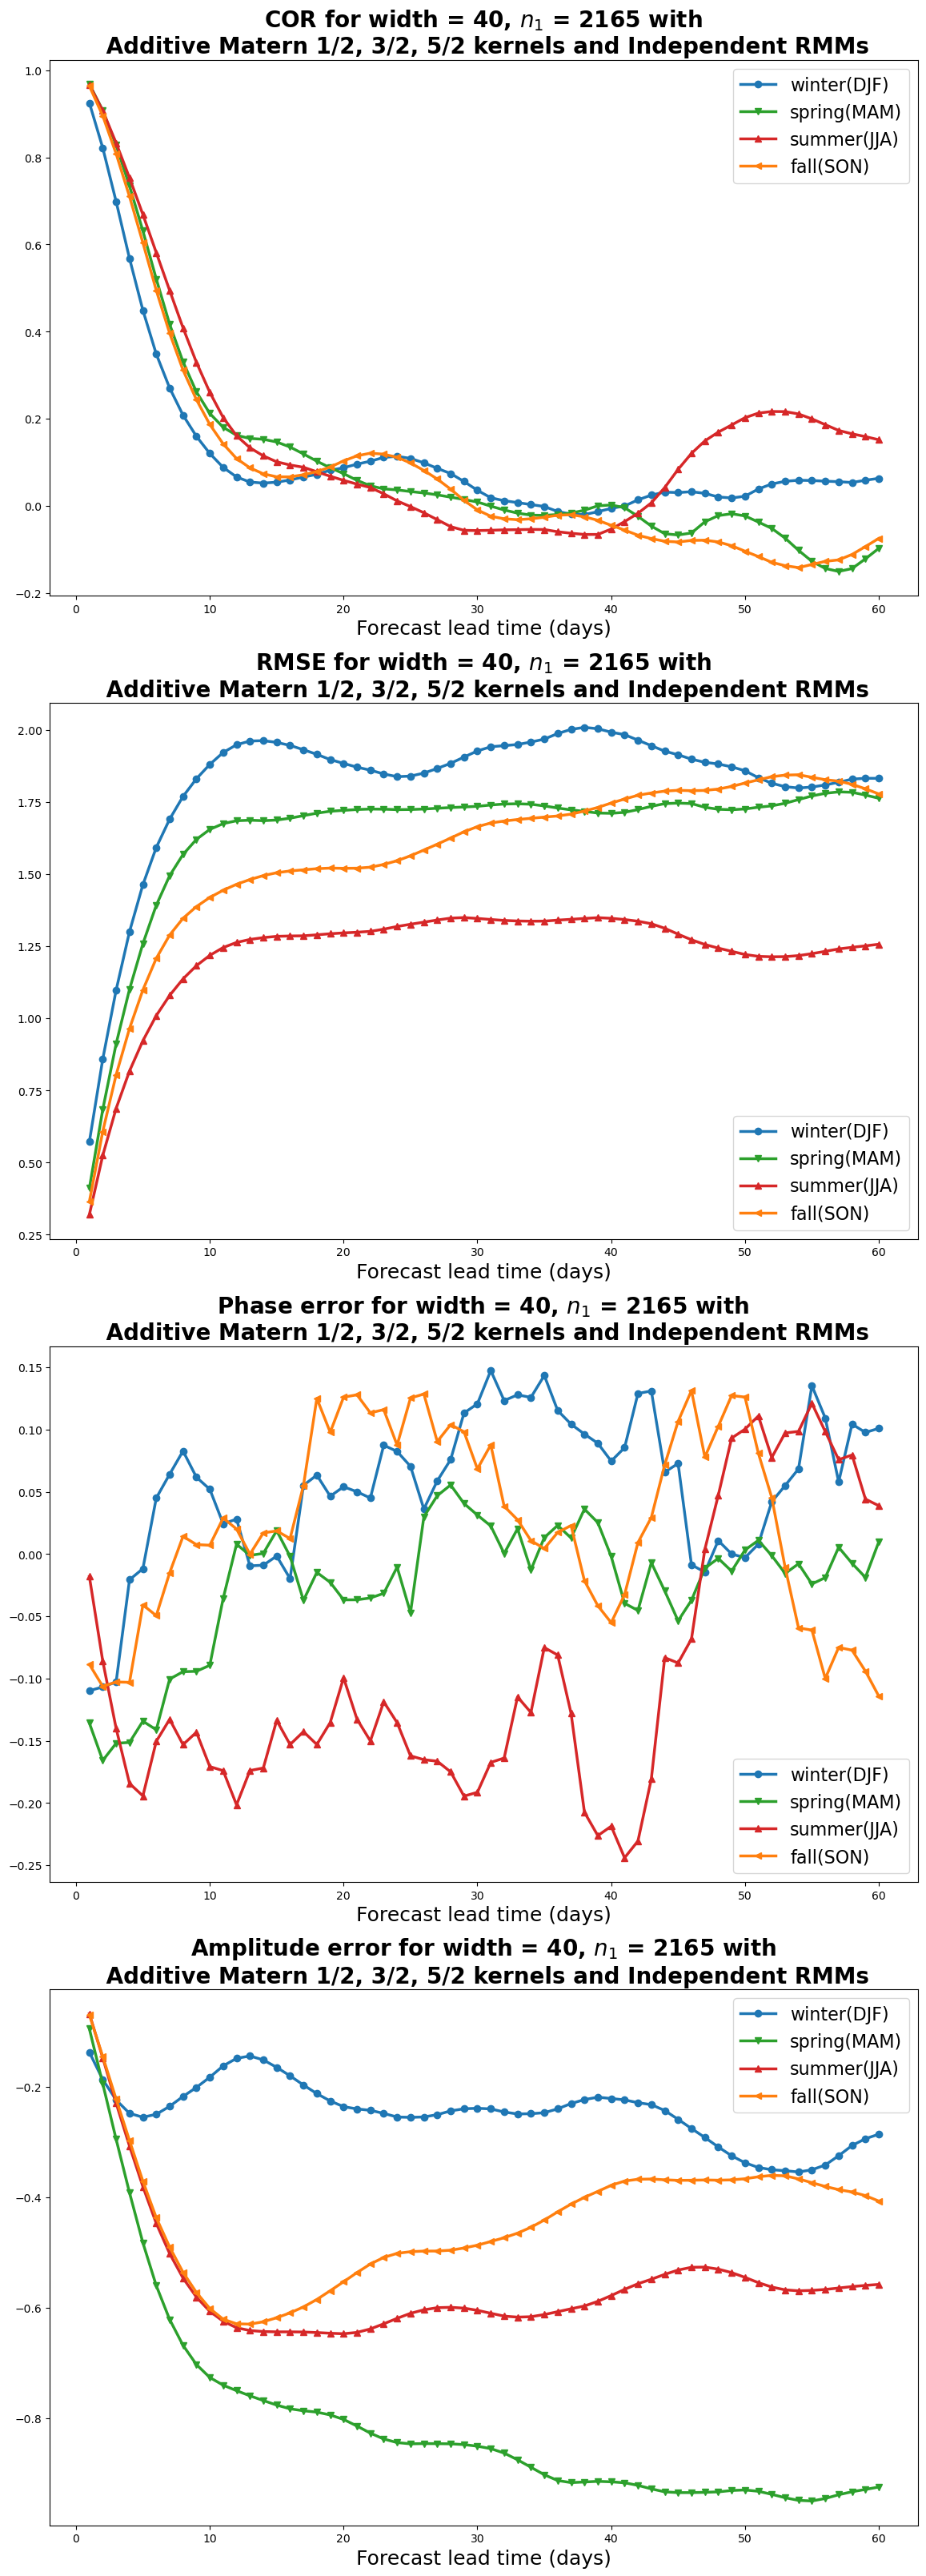

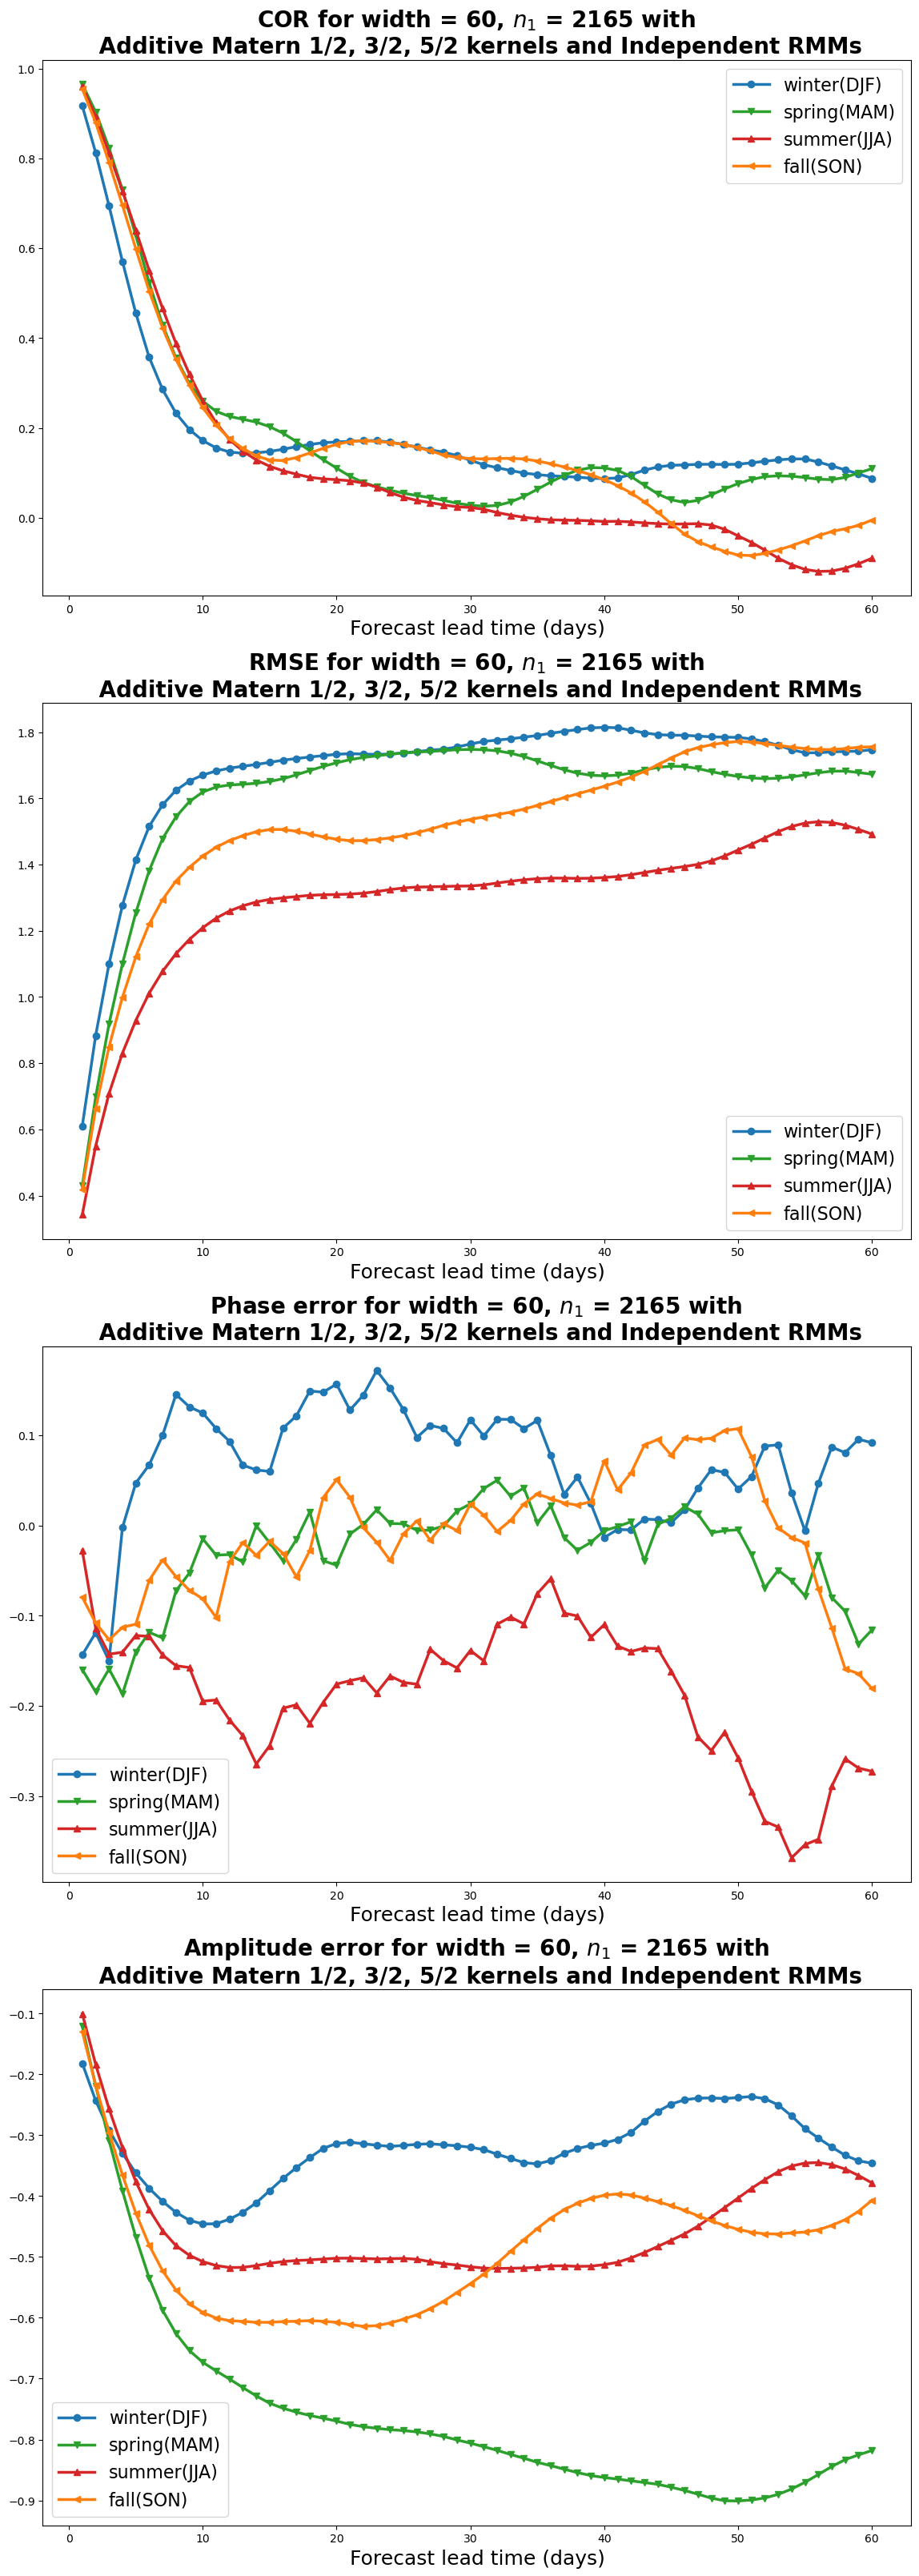

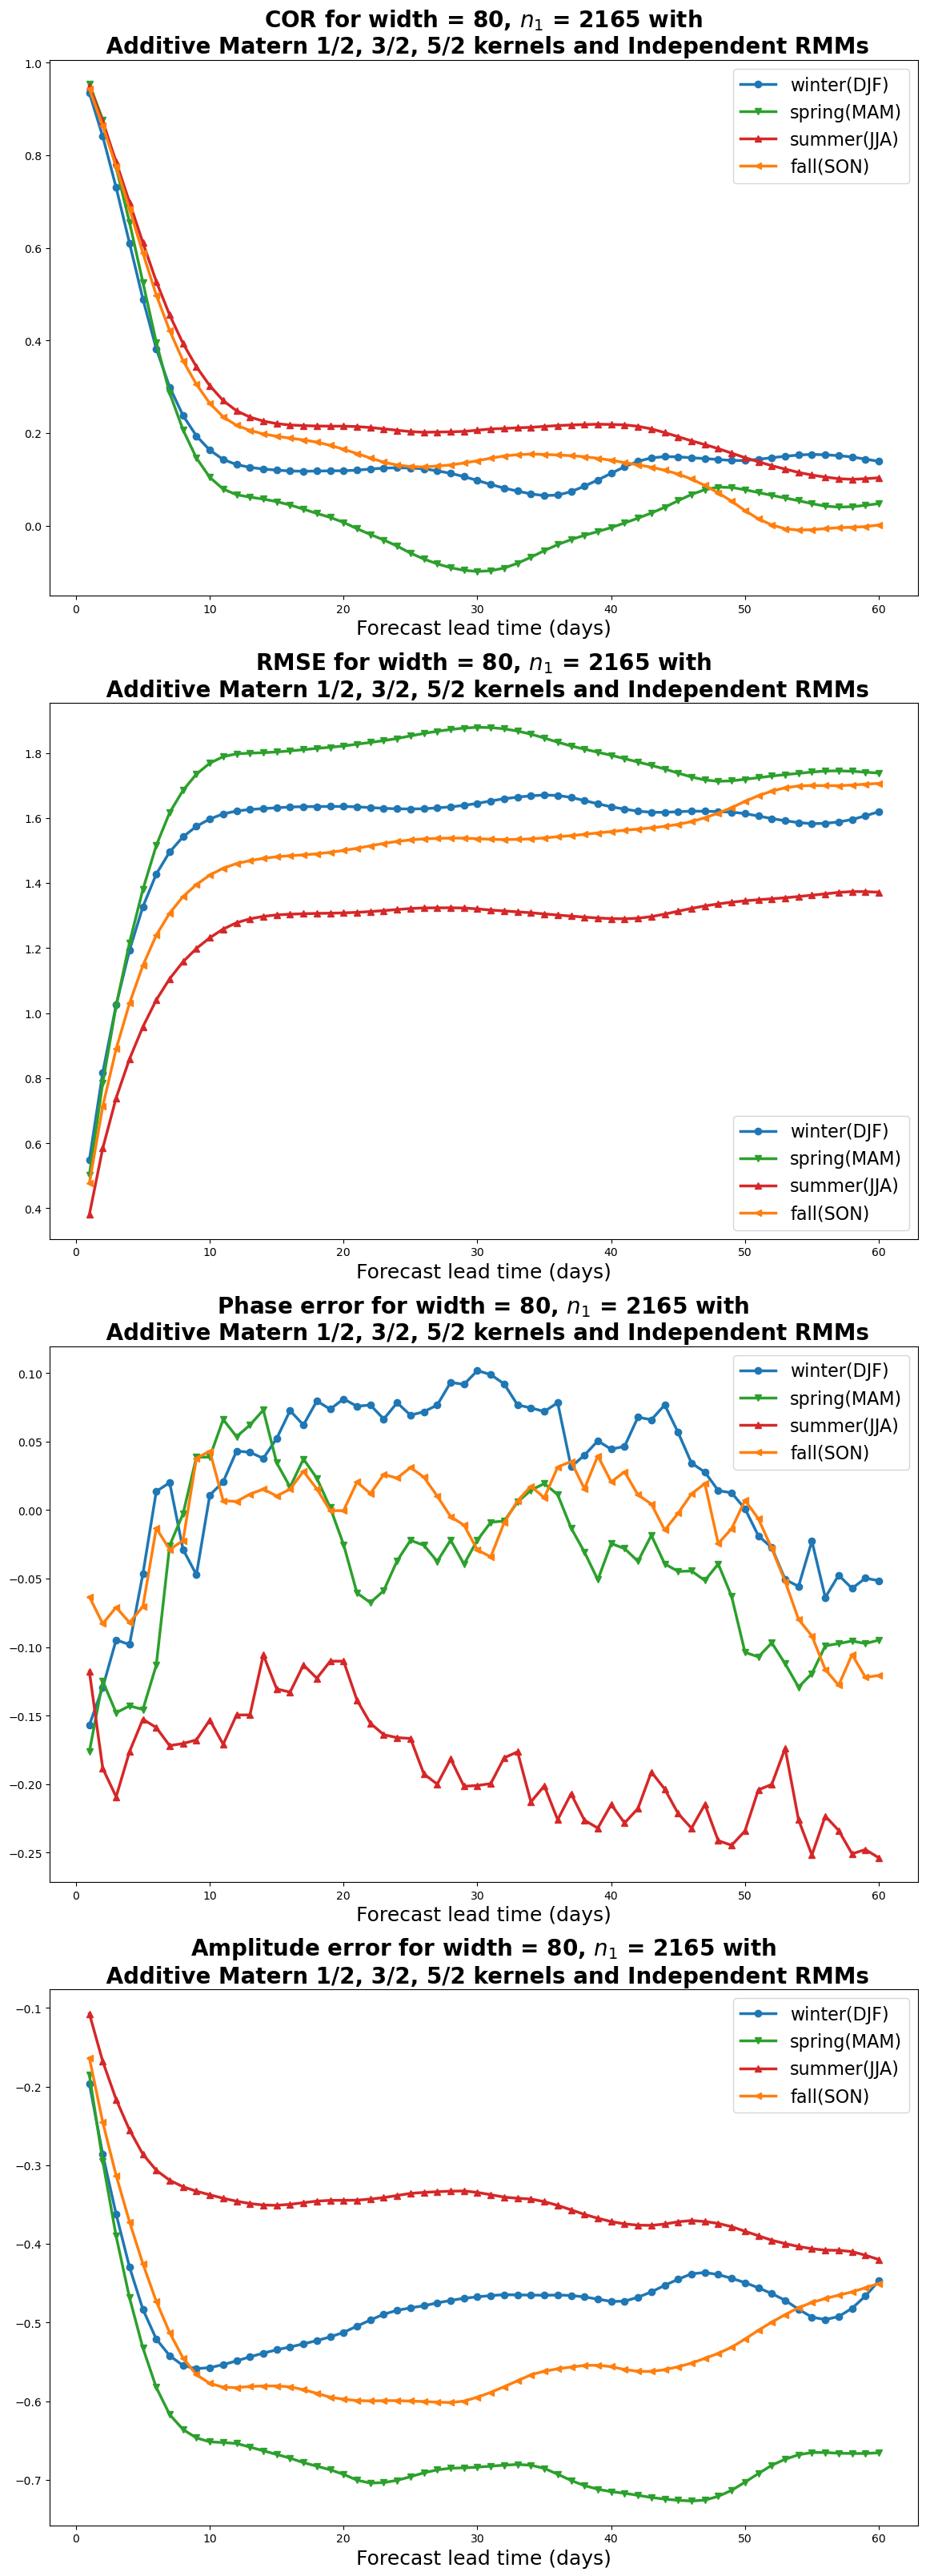

In [8]:
load_file = open('../data/preds/season/maternsum_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())


# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs

In [9]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern import MaternAdditiveKernel
kernel = MaternAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_dependadditivematern = {}
cor_total_dependadditivematern = {}
rmse_total_dependadditivematern = {}
phase_err_total_dependadditivematern = {}
amplitude_err_total_dependadditivematern = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscales", "weights"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_dependadditivematern[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo(Depend=True)
            for data_name in ['RMM1','RMM2']:
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
            weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
            t.add_rows( [[f'{season}', f'{width}', 'dependent', 
                              f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                              f'{weights}']] )

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_dependadditivematern[season] = cor_n1
    rmse_total_dependadditivematern[season] = rmse_n1
    phase_err_total_dependadditivematern[season] = phase_err_n1
    amplitude_err_total_dependadditivematern[season] = amplitude_err_n1

maternsum_depend = {'cor': cor_total_dependadditivematern, 'rmse': rmse_total_dependadditivematern, 
                     'phase': phase_err_total_dependadditivematern, 'amplitude': amplitude_err_total_dependadditivematern,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/maternsum_depend.pkl','wb')
pickle.dump(maternsum_depend, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with dependent RMMs:'))
print(t)

$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 with dependent RMMs:

+--------+-------+-----------+------------------------------------+------------------------------------------------+
| season | width |    RMMs   |            lengthscales            |                    weights                     |
+--------+-------+-----------+------------------------------------+------------------------------------------------+
| winter |   40  | dependent |  [4.7211747 6.7106323 6.5037494]   | [6.45034423e-04 1.16830785e-02 9.87671852e-01] |
| winter |   60  | dependent | [ 9.5984535 10.01658   11.760846 ] |  [9.3937325e-07 3.6651101e-05 9.9996239e-01]   |
| winter |   80  | dependent |  [12.102116 13.637189 14.39599 ]   |  [2.1646707e-09 5.1598556e-07 9.9999946e-01]   |
| spring |   40  | dependent | [12.021308   1.4652532 26.281717 ] |    [4.868175e-09 9.969505e-03 9.900305e-01]    |
| spring |   60  | dependent |  [12.101535  2.589918 31.204367]   |  [2.0135398e-09 2.3466121e-02 9.7653389e-01]   |
| spring |   80  | dependent |  [12.148391  3.512443 36.248833] 

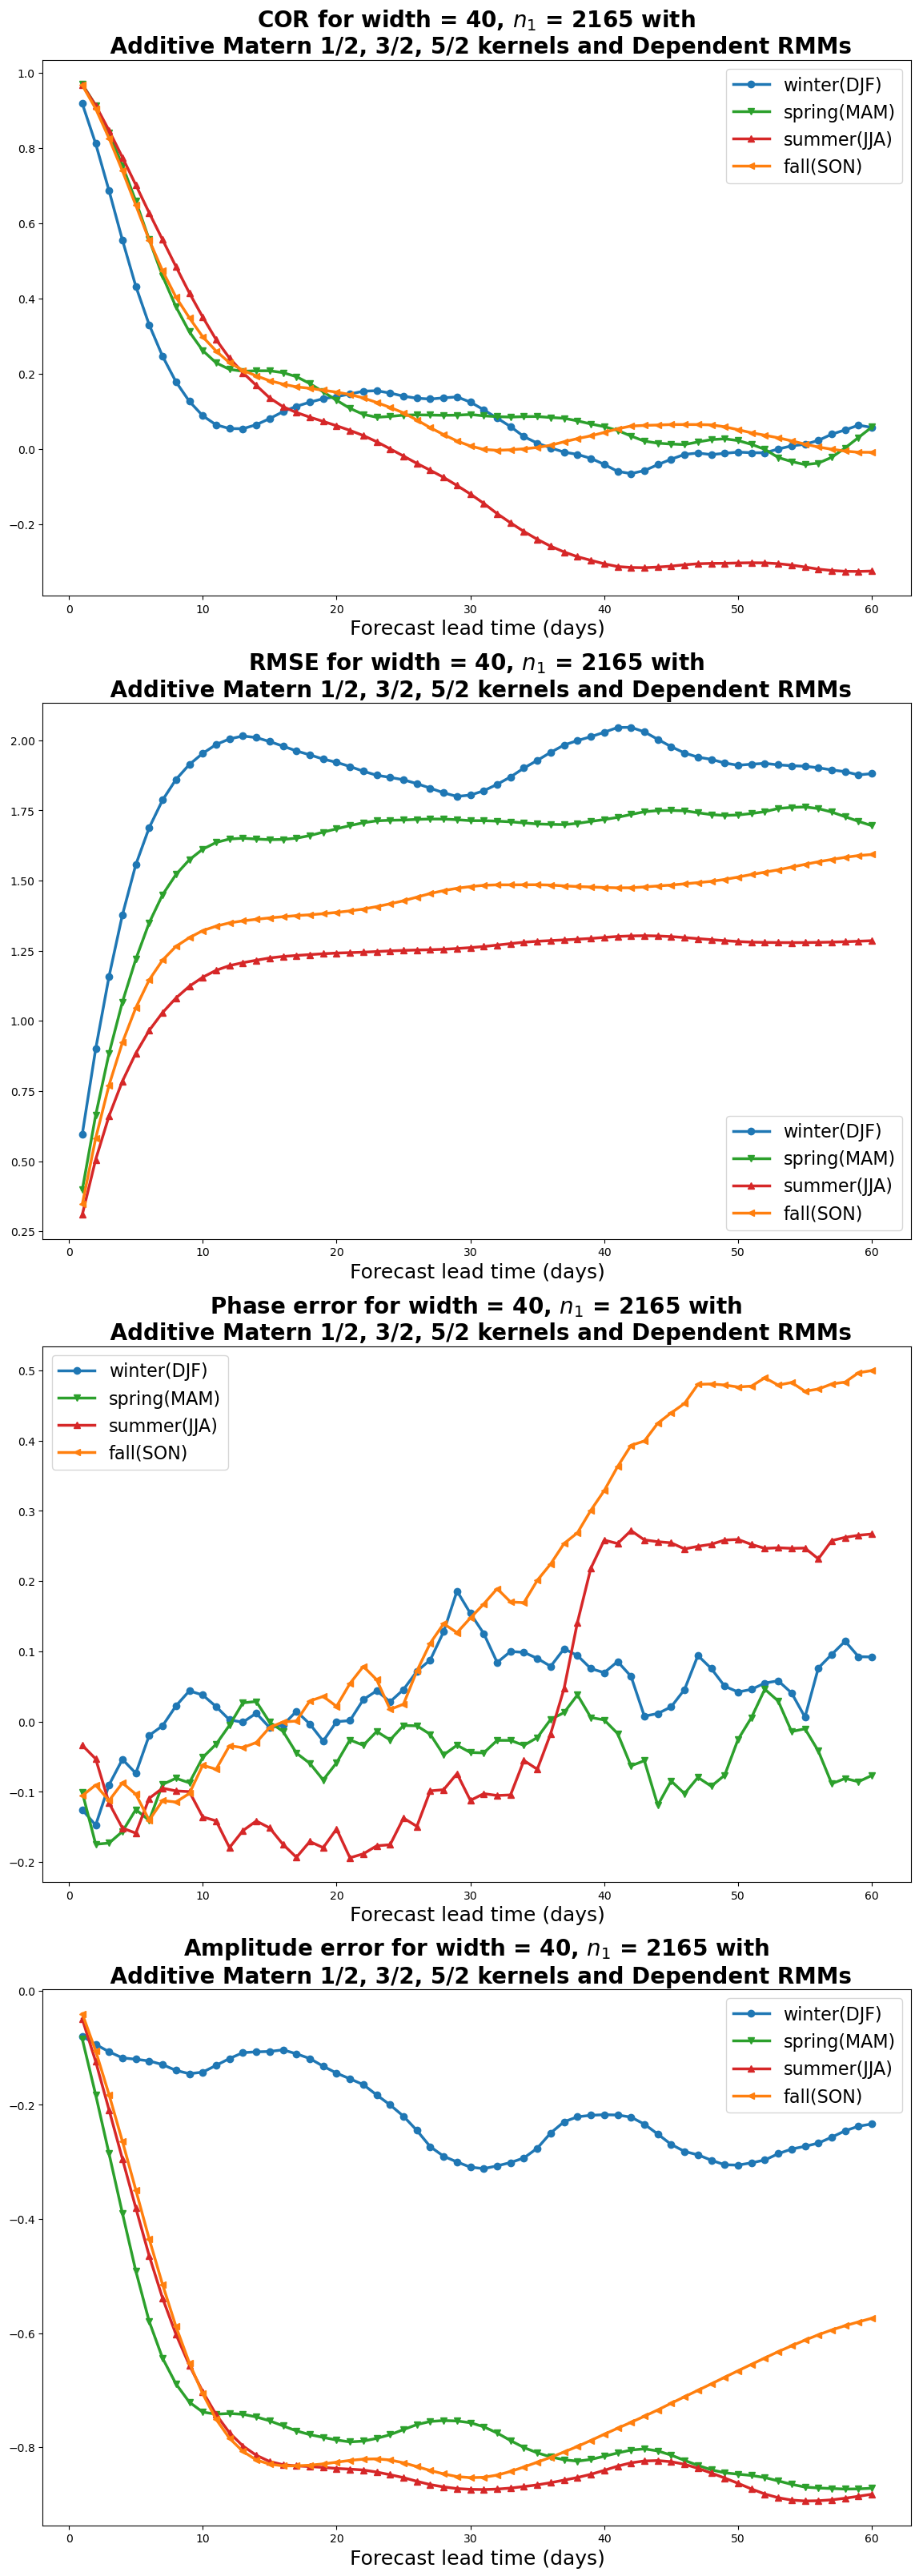

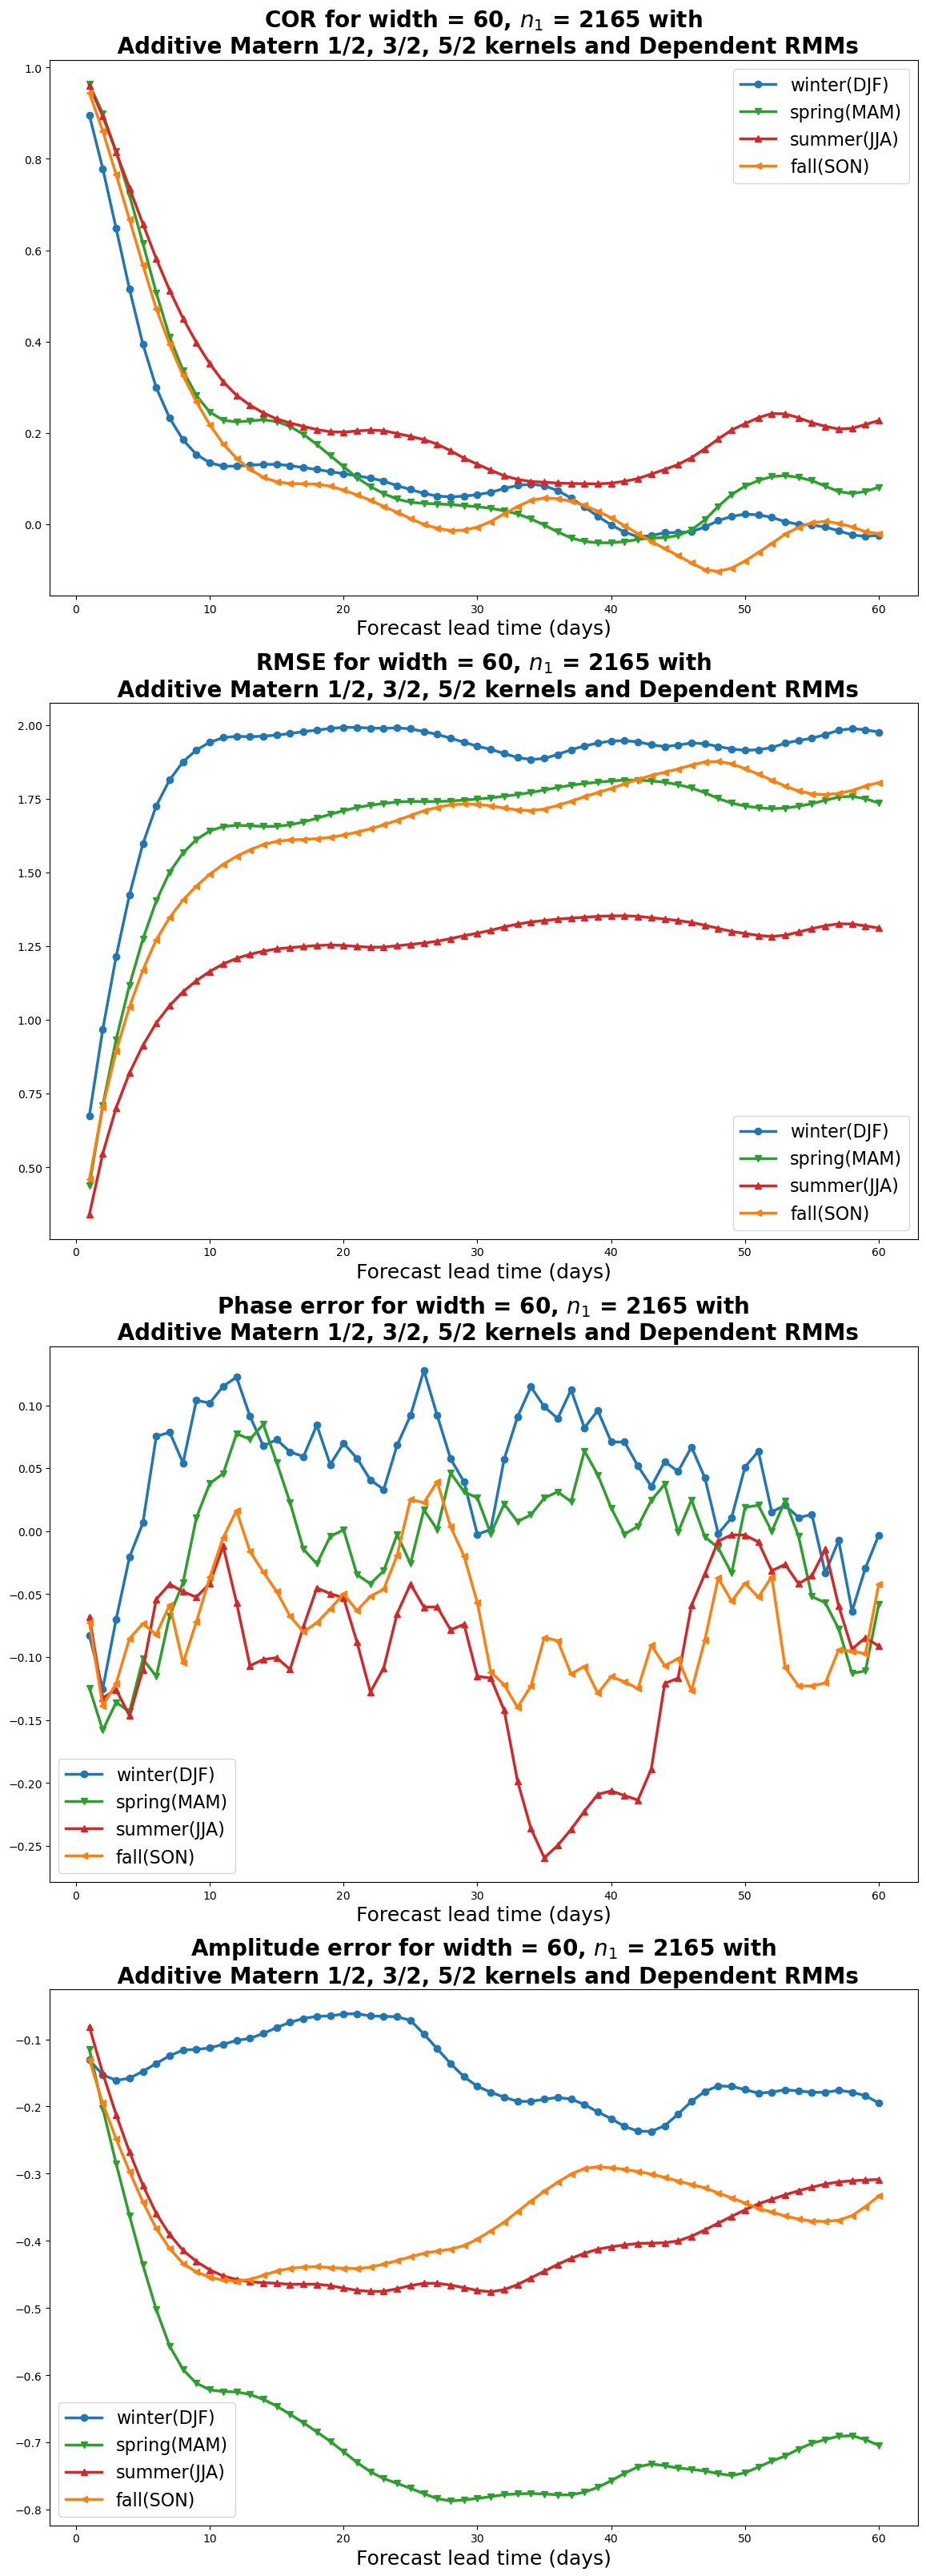

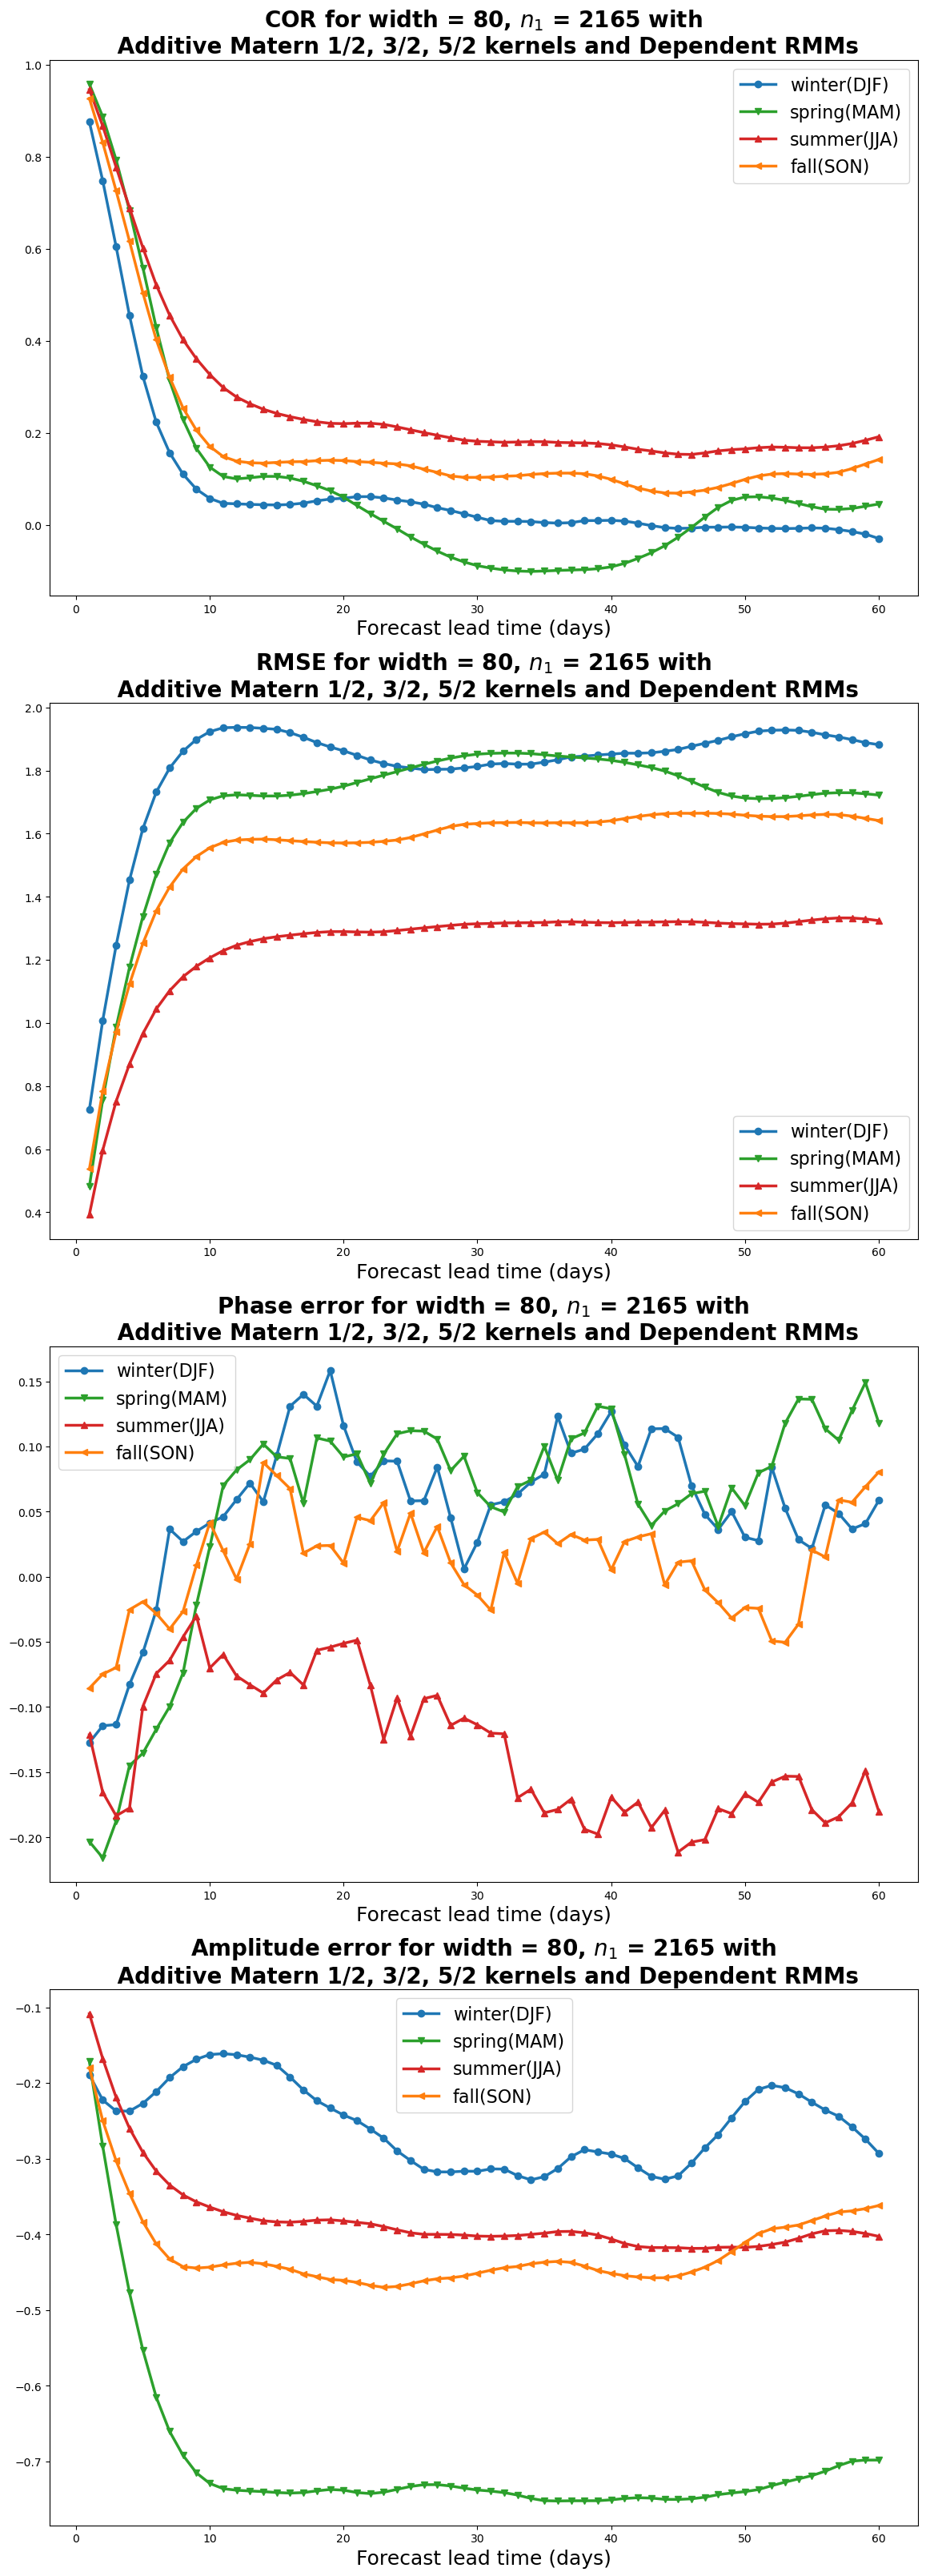

In [10]:
load_file = open('../data/preds/season/maternsum_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())

# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Additive Matern 1/2, 3/2, 5/2 kernels and Dependent RMMs', fontsize=20, fontweight="bold")

## $w_1$ $Mat\acute{e}rn$ $1/2$ + $w_2$ $Mat\acute{e}rn$ $3/2$ + $w_3$ $Mat\acute{e}rn$ $5/2$ + $w_4$ Periodic

### Independent RMMs

In [7]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern_period import CustomAdditiveKernel
kernel = CustomAdditiveKernel(lengthscale_unique = False)

# Independent
dics_total_additiveperiod = {}
cor_total_additiveperiod = {}
rmse_total_additiveperiod = {}
phase_err_total_additiveperiod = {}
amplitude_err_total_additiveperiod = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscales", "weights"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_additiveperiod[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            for data_name in ['RMM1','RMM2']:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
                
                weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
                t.add_rows( [[f'{season}', f'{width}', f'{data_name}', 
                              f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}',
                              f'{weights}']] )

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_additiveperiod[season] = cor_n1
    rmse_total_additiveperiod[season] = rmse_n1
    phase_err_total_additiveperiod[season] = phase_err_n1
    amplitude_err_total_additiveperiod[season] = amplitude_err_n1

periodsum_independ = {'cor': cor_total_additiveperiod, 'rmse': rmse_total_additiveperiod, 
                     'phase': phase_err_total_additiveperiod, 'amplitude': amplitude_err_total_additiveperiod,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/periodsum_independ.pkl','wb')
pickle.dump(periodsum_independ, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 + $w_4$ Periodic with independent RMMs:'))
print(t)

In [ ]:
load_file = open('../data/preds/season/periodsum_independ.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())


# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Independent RMMs', fontsize=20, fontweight="bold")

### Dependent RMMs

In [ ]:
from IPython.display import display, Markdown
from gp_mjo.kernels.additive_matern_period import CustomAdditiveKernel
kernel = CustomAdditiveKernel(lengthscale_unique = False)

# Dependent
dics_total_dependadditiveperiod = {}
cor_total_dependadditiveperiod = {}
rmse_total_dependadditiveperiod = {}
phase_err_total_dependadditiveperiod = {}
amplitude_err_total_dependadditiveperiod = {}

t = PrettyTable(["season", "width", "RMMs", "lengthscales", "weights"])

for m, season in zip(ms,seasons):

    cor_n1 = {}
    rmse_n1 = {}
    phase_err_n1 = {}
    amplitude_err_n1 = {}
    for n1 in n1s:
        dics, dics_ids = dics_divide(season_datas[season], data_names, n1, m, n, c)
        dics_total_dependadditiveperiod[n1] = dics

        cor_width = {}
        rmse_width = {}
        phase_err_width = {}
        amplitude_err_width = {}
        for width in widths:
            mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
            mjo_model.train_mjo(Depend=True)
            for data_name in ['RMM1','RMM2']:
                mjo_model.pred_mjo(data_name, lead_time, n_pred)
            weights = mjo_model.model.covar_module.base_kernel.weights.detach().numpy() / mjo_model.model.covar_module.base_kernel.weights.detach().numpy().sum()
            t.add_rows( [[f'{season}', f'{width}', 'dependent', 
                          f'{mjo_model.model.covar_module.base_kernel.lengthscales.detach().numpy()}', 
                          f'{weights}']] )

            # compute errors
            mjo_model.obs_extract()
            cor_width[width] = mjo_model.cor()
            rmse_width[width] = mjo_model.rmse()
            phase_err_width[width] = mjo_model.phase_err()
            amplitude_err_width[width] = mjo_model.amplitude_err()
            
        cor_n1[n1] = cor_width
        rmse_n1[n1] = rmse_width
        phase_err_n1[n1] = phase_err_width
        amplitude_err_n1[n1] = amplitude_err_width
    
    cor_total_dependadditiveperiod[season] = cor_n1
    rmse_total_dependadditiveperiod[season] = rmse_n1
    phase_err_total_dependadditiveperiod[season] = phase_err_n1
    amplitude_err_total_dependadditiveperiod[season] = amplitude_err_n1

periodsum_depend = {'cor': cor_total_dependadditiveperiod, 'rmse': rmse_total_dependadditiveperiod, 
                     'phase': phase_err_total_dependadditiveperiod, 'amplitude': amplitude_err_total_dependadditiveperiod,
                     'paras': t.get_string()}
dic_pkl = open('../data/preds/season/periodsum_depend.pkl','wb')
pickle.dump(periodsum_depend, dic_pkl)

display(Markdown(rf'$w_1$ Matern 1/2 + $w_2$ Matern 3/2 + $w_3$ Matern 5/2 + $w_4$ Periodic with dependent RMMs:'))
print(t)

In [ ]:
load_file = open('../data/preds/season/periodsum_depend.pkl', 'rb')
dic_file = pickle.load(load_file)
seasons = list(dic_file['cor'].keys())
n1s = list(dic_file['cor']['winter'].keys())
widths = list(dic_file['cor']['winter'][n1s[0]].keys())

# Plot
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
#plot_colors = palette_colors[:len(seasons)]
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]

season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']

for n1 in n1s:
    for width in widths:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for season, color, marker in zip(seasons, plot_colors, plot_markers):
            _cor = dic_file['cor'][season][n1][width]
            _rmse = dic_file['rmse'][season][n1][width]
            _phase_err = dic_file['phase'][season][n1][width]
            _amplitude_err = dic_file['amplitude'][season][n1][width]
            
            
            axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
            axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
            axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
            axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

        for i, mjo_err in enumerate(mjo_errs):
            axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
            axs[i].legend(season_months, fontsize=16)
            axs[i].set_title(f'{mjo_err} for width = {width}, $n_1$ = {n1} with \n Additive Matern and Periodic kernels and Dependent RMMs', fontsize=20, fontweight="bold")

## Block Kernels for Dependent RMMs